## process scATAC data and get gene activities

In [1]:
suppressMessages({library(Signac)
library(Seurat)
library(ggplot2)
library(patchwork)
library(hdf5r)
library(SeuratData)
library(EnsDb.Hsapiens.v86)
library(ggplot2)
library(cowplot)
library(GenomeInfoDb)
library(stringr)
library(patchwork)
library(SeuratDisk)
library(dplyr)})

In [2]:
input_dir = "../../../results/Fig1_Fig2_Fig3_SFig1-FACS_BM_scATAC/Fig3-apply_seurat_label_transfer/01_prepare_input_files/"

In [3]:
counts <- Read10X_h5(filename = paste(input_dir ,"scATAC_BM_Corces2018_ENCODE_coverage_per_cell_matrix_nonZero.h5", sep=''))

In [5]:
any(is.na((counts)))

[1] FALSE

In [6]:
NCOL(counts)

[1] 2182

In [6]:
#counts <- Read10X_h5(filename = "../vignette_data/atac_v1_pbmc_10k_filtered_peak_bc_matrix.h5")
metadata <- read.csv(
  file =  paste(input_dir ,"singlecell.csv", sep=''),
  header = TRUE,
  row.names = 1
)


In [7]:
chrom_assay <- CreateChromatinAssay(
  counts = counts,
  sep = c("_", "_"),
  fragments =paste(input_dir ,"Corces2018_BM_FACS_scATAC_fragments_reorganized_tab_sorted.sort.bed.gz", sep=''),
  min.cells = 10,
  min.features = 200
)


Warning message in CreateChromatinAssay(counts = counts, sep = c("_", "_"), fragments = paste(input_dir, :
"Overlapping ranges supplied. Ranges should be non-overlapping."
Computing hash



In [8]:
chrom_assay

ChromatinAssay data with 267309 features for 2020 cells
Variable features: 0 
Genome: 
Annotation present: FALSE 
Motifs present: FALSE 
Fragment files: 1 

In [9]:

bm <- CreateSeuratObject(
  counts = chrom_assay,
  assay = "peaks",
  meta.data = metadata
)

Warning message in CreateSeuratObject.Assay(counts = chrom_assay, assay = "peaks", :
"Some cells in meta.data not present in provided counts matrix."
Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from peaks to peaks_"


In [10]:
bm[['peaks']]

ChromatinAssay data with 267309 features for 2020 cells
Variable features: 0 
Genome: 
Annotation present: FALSE 
Motifs present: FALSE 
Fragment files: 1 

In [11]:
# add gene annotation information
annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v86)
ucsc.levels <- str_replace(string=paste("chr",seqlevels(annotations),sep=""), pattern="chrMT", replacement="chrM")
seqlevels(annotations) <- ucsc.levels
genome(annotations) <- "hg38"
Annotation(bm) <- annotations



Warning message:
"no function found corresponding to methods exports from 'BSgenome' for: 'releaseName'"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppre

In [12]:
Annotation(bm) <- annotations

In [13]:
# compute nucleosome signal score per cell
bm <- NucleosomeSignal(object = bm)

# compute TSS enrichment score per cell
bm <- TSSEnrichment(object = bm, fast = FALSE)


Extracting TSS positions

Finding + strand cut sites

Finding - strand cut sites

Computing mean insertion frequency in flanking regions

Normalizing TSS score



In [15]:
#Signac::DensityScatter(bm, x = 'nCount_peaks', y = 'TSS.enrichment', log_x = TRUE, quantiles = TRUE)

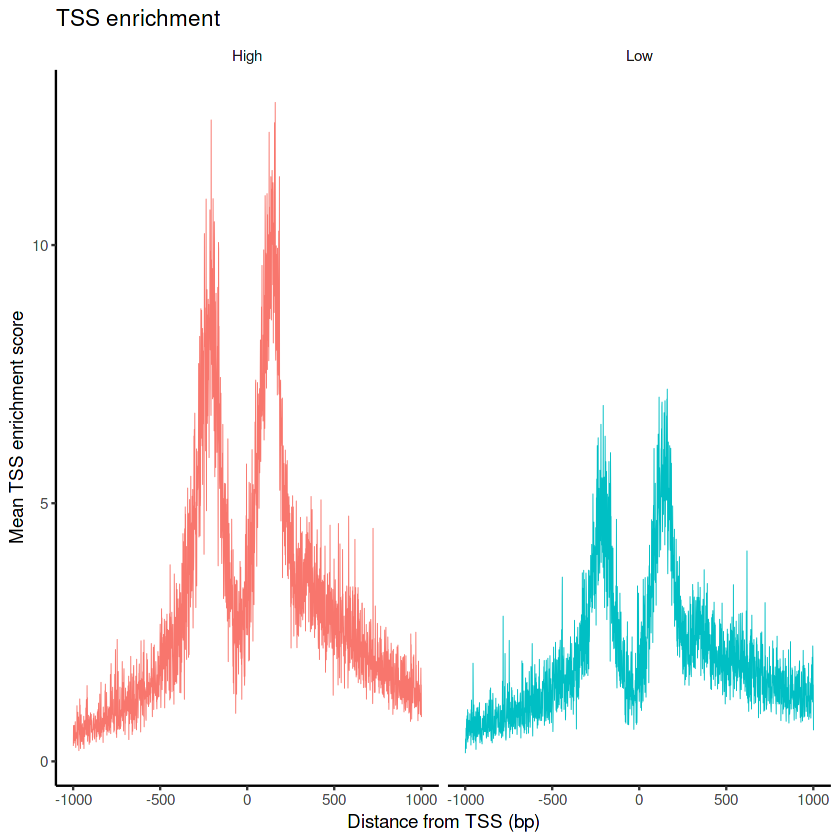

In [14]:
bm$high.tss <- ifelse(bm$TSS.enrichment > 3, 'High', 'Low')
TSSPlot(bm, group.by = 'high.tss') + NoLegend()

In [15]:
head(bm@meta.data)

,orig.ident,nCount_peaks,nFeature_peaks,is_cell,atac_fragments,nucleosome_signal,nucleosome_percentile,TSS.enrichment,TSS.percentile,high.tss
,<fct>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
CLP_0,CLP,708,422,1,743,Inf,1,7.215007,0.99,High
CLP_1,CLP,2676,1422,1,2822,Inf,1,4.999083,0.75,High
CMP_0,CMP,5650,2982,1,5954,Inf,1,5.832143,0.94,High
CMP_1,CMP,7369,3891,1,7741,Inf,1,5.094905,0.78,High
CMP_2,CMP,7947,4223,1,8643,Inf,1,5.307090,0.85,High
CMP_3,CMP,8601,4548,1,9309,Inf,1,4.478280,0.48,High


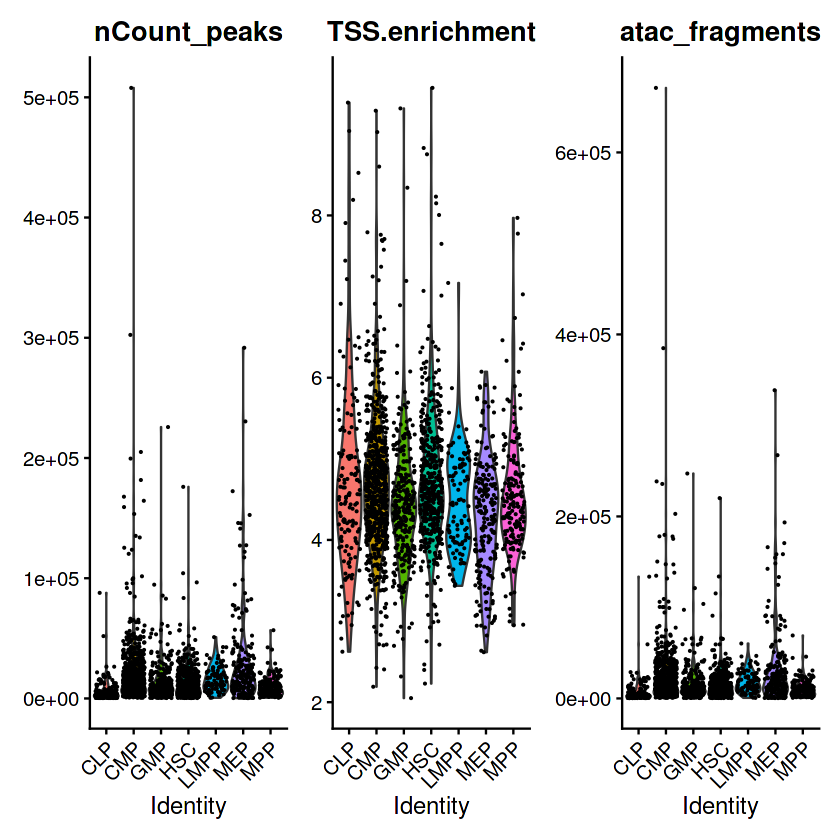

In [16]:
VlnPlot(
  object = bm,
  features = c('nCount_peaks', 'TSS.enrichment', 'atac_fragments'),
  pt.size = 0.1,
  ncol = 3
)

In [17]:
bm

An object of class Seurat 
267309 features across 2020 samples within 1 assay 
Active assay: peaks (267309 features, 0 variable features)

In [18]:
bm_filt <- subset(
  x = bm,
  subset = nCount_peaks > 300 &
    nCount_peaks < 300000 
)
bm_filt

An object of class Seurat 
267309 features across 2017 samples within 1 assay 
Active assay: peaks (267309 features, 0 variable features)

In [19]:
bm_filt <- RunTFIDF(bm_filt)
bm_filt <- FindTopFeatures(bm_filt, min.cutoff = 'q0')
bm_filt <- RunSVD(bm_filt)

Performing TF-IDF normalization

Running SVD

Scaling cell embeddings



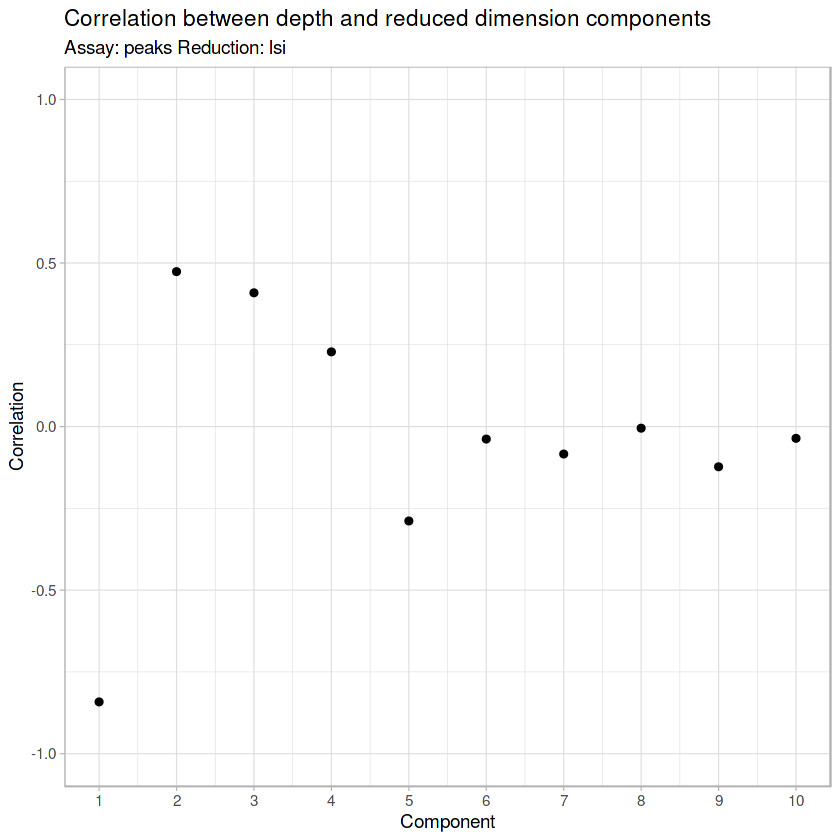

In [20]:
DepthCor(bm_filt)

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
11:20:59 UMAP embedding parameters a = 0.9922 b = 1.112

11:20:59 Read 2017 rows and found 29 numeric columns

11:20:59 Using Annoy for neighbor search, n_neighbors = 30

11:20:59 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

11:21:00 Writing NN index file to temp file /scratch/local/RtmpspWcDr/file13d644dc93eac

11:21:00 Searching Annoy index using 1 thread, search_k = 3000

11:21:00 Annoy recall = 100%

11:21:02 Commencing smooth kNN distance calibration using 1 thread
 with target n_

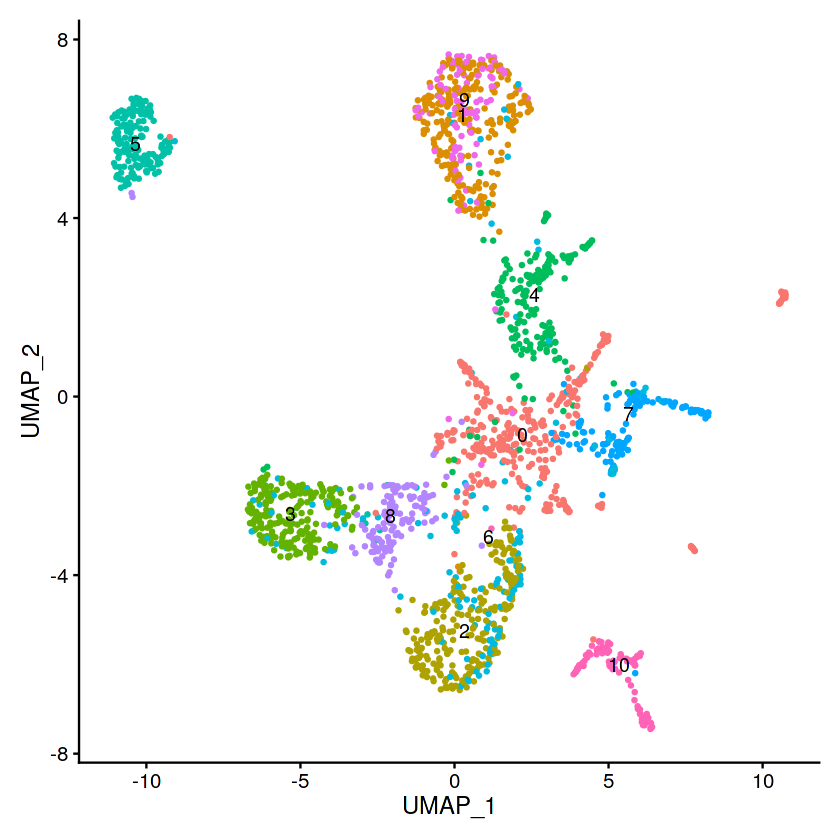

In [21]:
bm_filt <- RunUMAP(object = bm_filt, reduction = 'lsi', dims = 2:30)
bm_filt <- FindNeighbors(object = bm_filt, reduction = 'lsi', dims = 2:30)
bm_filt <- FindClusters(object = bm_filt, verbose = FALSE, algorithm = 3)
DimPlot(object = bm_filt, label = TRUE) + NoLegend()

In [22]:
gene.activities <- GeneActivity(bm_filt)

Extracting gene coordinates

Extracting reads overlapping genomic regions



In [23]:
# add the gene activity matrix to the Seurat object as a new assay and normalize it
bm_filt[['RNA']] <- CreateAssayObject(counts = gene.activities)
bm_filt <- NormalizeData(
  object = bm_filt,
  assay = 'RNA',
  normalization.method = 'LogNormalize',
  scale.factor = median(bm_filt$nCount_RNA)
)

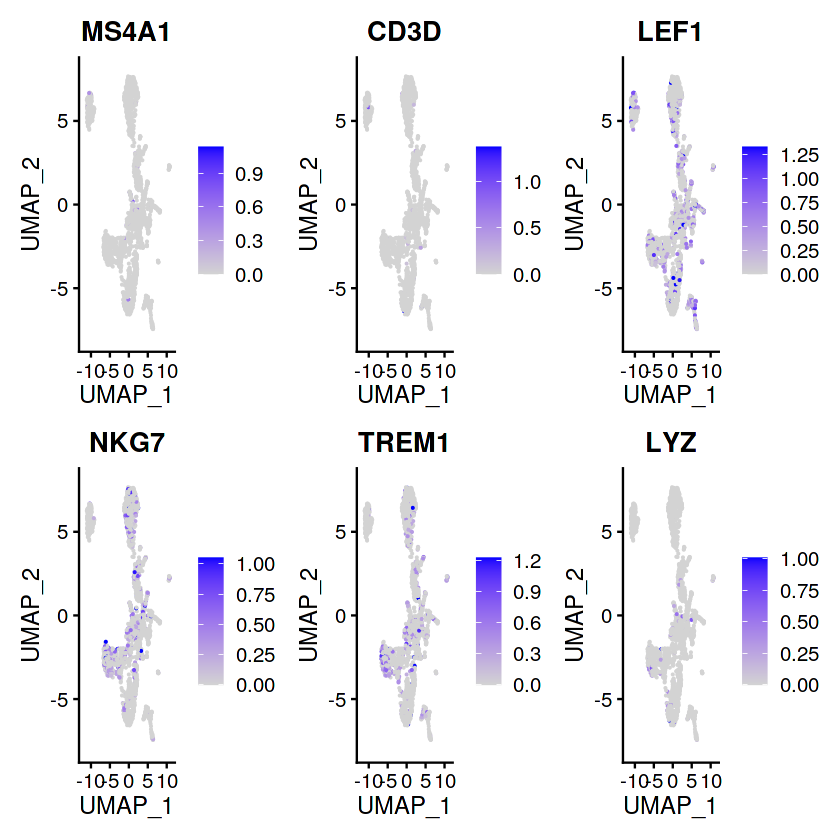

In [24]:
DefaultAssay(bm_filt) <- 'RNA'

FeaturePlot(
  object = bm_filt,
  features = c('MS4A1', 'CD3D', 'LEF1', 'NKG7', 'TREM1', 'LYZ'),
  pt.size = 0.1,
  max.cutoff = 'q95',
  ncol = 3
)

## apply label transfer using bm CITE-seq data

In [25]:
# load reference data
bm_ref <- LoadData(ds = "bmcite")


UMAP will return its model

11:23:30 UMAP embedding parameters a = 0.9922 b = 1.112

11:23:31 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 20

11:23:32 Initializing from normalized Laplacian + noise (using irlba)

11:23:35 Commencing optimization for 200 epochs, with 983596 positive edges

11:23:52 Optimization finished

11:23:52 Note: model requested with precomputed neighbors. For transforming new data, distance data must be provided separately



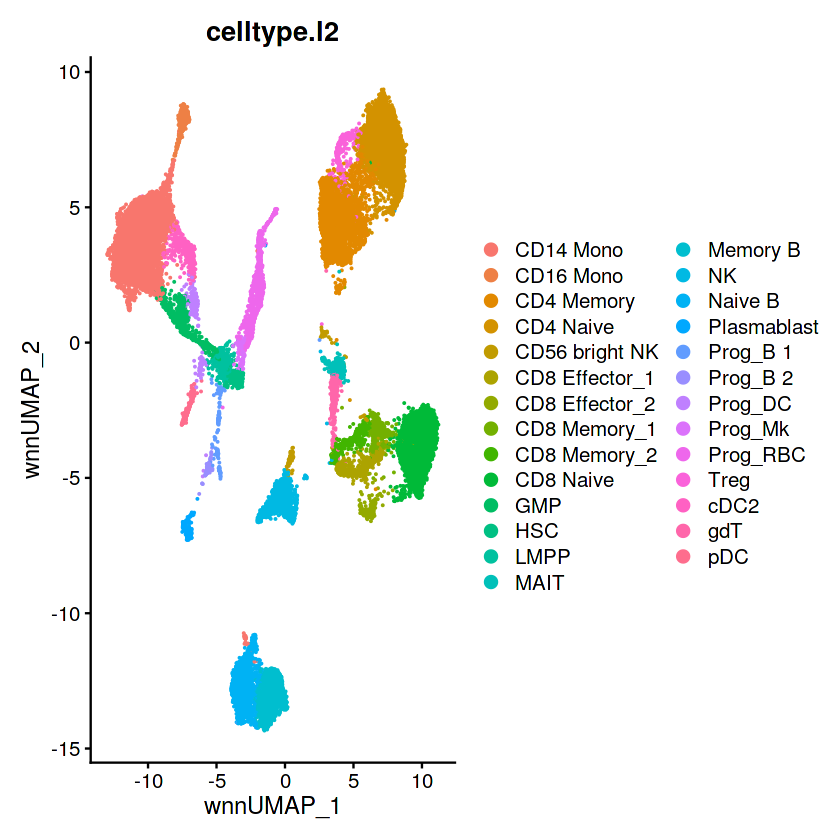

In [26]:
bm_ref <- RunUMAP(bm_ref, nn.name = "weighted.nn", reduction.name = "wnn.umap", 
              reduction.key = "wnnUMAP_", return.model = TRUE)
DimPlot(bm_ref, group.by = "celltype.l2", reduction = "wnn.umap") 

In [27]:
bm_ref <- ScaleData(bm_ref, assay = 'RNA')
bm_ref <- RunSPCA(bm_ref, assay = 'RNA', graph = 'wsnn')

Centering and scaling data matrix

Computing sPCA transformation



### as per the guidelines, both the refernece and the query should have the same normalization method applied for label trasfer. As gene.activity matrix can only have log transformation, we should apply the same for the reference as well.

In [28]:
bm_ref

An object of class Seurat 
17034 features across 30672 samples within 2 assays 
Active assay: RNA (17009 features, 2000 variable features)
 1 other assay present: ADT
 2 dimensional reductions calculated: spca, wnn.umap

In [29]:
bm_ref_logTransformedRNA <- CreateAssayObject(counts = bm_ref@assays$RNA@counts)

In [30]:
bm_ref[["logTransformedRNA"]] <- bm_ref_logTransformedRNA

In [31]:
DefaultAssay(bm_ref) <- "logTransformedRNA"

In [32]:
bm_ref

An object of class Seurat 
34043 features across 30672 samples within 3 assays 
Active assay: logTransformedRNA (17009 features, 0 variable features)
 2 other assays present: RNA, ADT
 2 dimensional reductions calculated: spca, wnn.umap

In [33]:
bm_ref <- NormalizeData(
  bm_ref,
  normalization.method = "LogNormalize")

In [34]:
bm_ref@assays$logTransformedRNA

Assay data with 17009 features for 30672 cells
First 10 features:
 FO538757.2, AP006222.2, RP4-669L17.10, RP11-206L10.9, LINC00115,
FAM41C, SAMD11, NOC2L, KLHL17, PLEKHN1 

In [35]:
bm_ref <- FindVariableFeatures(bm_ref)
bm_ref <- ScaleData(bm_ref)
bm_ref <- RunPCA(bm_ref)
bm_ref <- RunUMAP(bm_ref, dims = 1:30)


Centering and scaling data matrix

PC_ 1 
Positive:  TRBC1, LAT, CD8B, CCL5, KLRB1, IGKC, S100A12, GZMA, S100A8, S100A9 
	   MS4A1, S100B, GNLY, CST7, TYROBP, KLRD1, RP11-291B21.2, NKG7, VCAN, CD14 
	   IGLC2, CCL4, AC092580.4, FCN1, IGLC3, PRF1, RBP7, SERPINA1, DUSP2, JUN 
Negative:  KIAA0101, TYMS, KLF1, KCNH2, FAM178B, APOC1, CNRIP1, CENPU, GATA1, BIRC5 
	   CENPF, EPCAM, CKS2, RP11-620J15.3, TUBA1B, TFR2, CA1, HMGA1, STMN1, HIST1H4C 
	   CDT1, AHSP, TOP2A, TK1, GFI1B, TUBB, MKI67, NME4, SMIM1, TMEM56 
PC_ 2 
Positive:  RPL3, RPS3, RPS18, RPS5, RPS4X, RPSA, RPS12, RPS23, RPS2, EEF1B2 
	   RPL4, LDHB, NPM1, RPS17, RPLP0, TRBC1, LAT, RPL7A, GYPC, HSPA8 
	   CD8B, KLRB1, CCL5, HNRNPA1, PEBP1, RPL37A, MYC, NUCB2, SOD1, CD79A 
Negative:  LYZ, FCN1, CST3, TYROBP, S100A9, LST1, S100A8, CSTA, MNDA, VCAN 
	   LGALS1, AIF1, S100A12, CFD, SERPINA1, FCER1G, MS4A6A, FOS, S100A6, CD14 
	   LGALS2, FTH1, GAPDH, ANXA2, CD36, CPVL, RBP7, HLA-DRA, LINC01272, H3F3A 
PC_ 3 
Positive:  CD74, HLA-DRA, HL

In [36]:
bm_ref <- RunSPCA(bm_ref, reduction.key = "SPC_logTr_", assay = 'logTransformedRNA', graph = 'wsnn')


Computing sPCA transformation

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from SPC_logTr_ to SPClogTr_"
Warning message:
"All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to SPClogTr_"


In [37]:
bm_ref

An object of class Seurat 
34043 features across 30672 samples within 3 assays 
Active assay: logTransformedRNA (17009 features, 2000 variable features)
 2 other assays present: RNA, ADT
 4 dimensional reductions calculated: spca, wnn.umap, pca, umap

In [38]:
bm_ref <- FindNeighbors(
  object = bm_ref,
  reduction = "spca",
  dims = 1:50,
  graph.name = "spca.annoy.neighbors", 
  k.param = 50,
  cache.index = TRUE,
  return.neighbor = TRUE,
  l2.norm = TRUE
)

Computing nearest neighbors

Only one graph name supplied, storing nearest-neighbor graph only



In [39]:
bm_ref

An object of class Seurat 
34043 features across 30672 samples within 3 assays 
Active assay: logTransformedRNA (17009 features, 2000 variable features)
 2 other assays present: RNA, ADT
 4 dimensional reductions calculated: spca, wnn.umap, pca, umap

In [40]:
# in the below function the defaults are ...
# FindMultiModalNeighbors( ...knn.graph.name = "wknn",
#   snn.graph.name = "wsnn",
#   weighted.nn.name = "weighted.nn",...)

In [41]:
bm_ref <- RunUMAP(bm_ref, nn.name = "weighted.nn", reduction.name = "wnn.umap", reduction.key = "wnnUMAP_")


11:30:16 UMAP embedding parameters a = 0.9922 b = 1.112

11:30:17 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 20

11:30:20 Initializing from normalized Laplacian + noise (using irlba)

11:30:23 Commencing optimization for 200 epochs, with 983596 positive edges

11:30:40 Optimization finished



In [42]:
bm_ref <- FindClusters(bm_ref, graph.name = "wsnn", algorithm = 3, resolution = 2, verbose = FALSE)

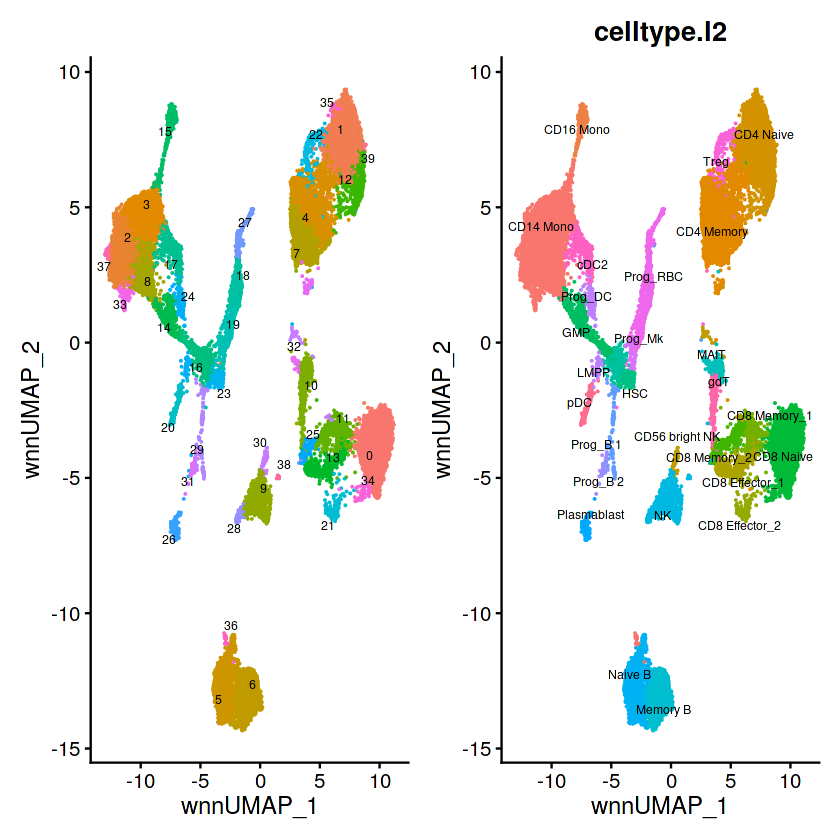

In [43]:
p1 <- DimPlot(bm_ref, reduction = 'wnn.umap', label = TRUE, repel = TRUE, label.size = 2.5) + NoLegend()
p2 <- DimPlot(bm_ref, reduction = 'wnn.umap', group.by = 'celltype.l2', label = TRUE, repel = TRUE, label.size = 2.5) + NoLegend()
p1 + p2

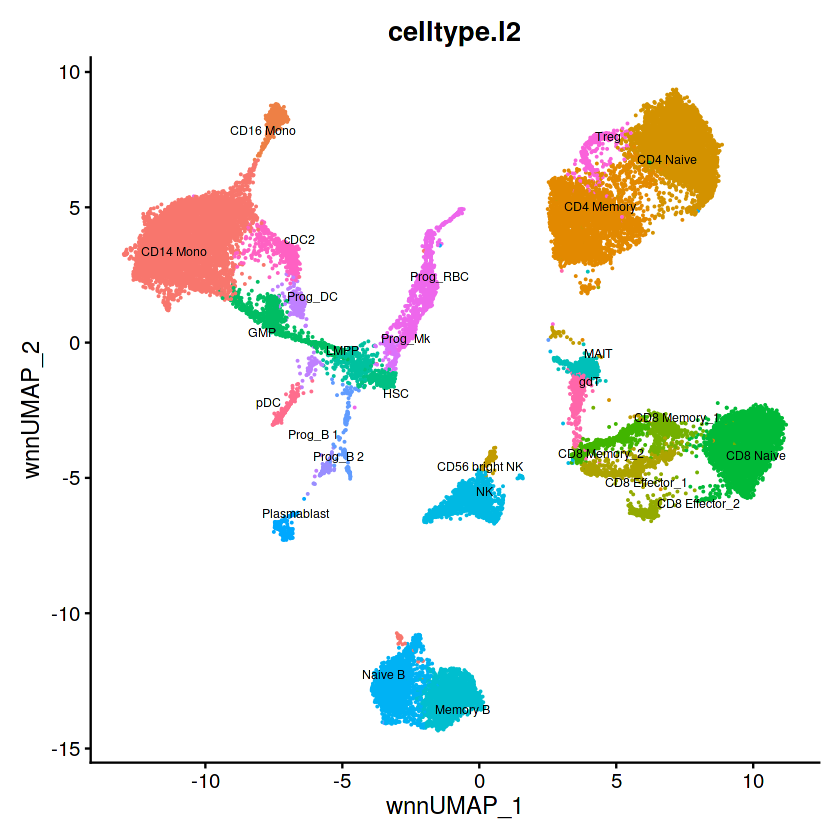

In [44]:
DimPlot(bm_ref, reduction = 'wnn.umap', group.by = 'celltype.l2', label = TRUE, repel = TRUE, label.size = 2.5) + NoLegend()


### get the variable features from gene activity object

In [51]:
bm_filt <- FindVariableFeatures(bm_filt, selection.method = "vst", nfeatures = 3000)

In [52]:
bm_filt

An object of class Seurat 
286916 features across 2017 samples within 2 assays 
Active assay: RNA (19607 features, 3000 variable features)
 1 other assay present: peaks
 2 dimensional reductions calculated: lsi, umap

## label transfer

In [53]:
bm_ref

An object of class Seurat 
34043 features across 30672 samples within 3 assays 
Active assay: logTransformedRNA (17009 features, 2000 variable features)
 2 other assays present: RNA, ADT
 4 dimensional reductions calculated: spca, wnn.umap, pca, umap

In [54]:
anchors <- FindTransferAnchors(
    reference = bm_ref,
    query = bm_filt,
    k.filter = NA,
    reference.reduction = "spca", 
    reference.neighbors = "spca.annoy.neighbors", 
    dims = 1:50,
    reference.assay = 'logTransformedRNA'
  )


Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 225 anchors



### through the standard pipeline we retained only a small number of anchors, so we will try with cca now..

In [55]:
bm.cca.anchors <- FindTransferAnchors(reference = bm_ref, query = bm_filt, reduction = 'cca', dims = 1:30, 
                               reference.assay = 'logTransformedRNA', query.assay = 'RNA', normalization.method = 'LogNormalize')


Warning message in RunCCA.Seurat(object1 = reference, object2 = query, features = features, :
"Running CCA on different assays"
Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 9916 anchors

Filtering anchors

	Retained 1940 anchors



### CCA resulted in much more anchors making this approach more reliable. Therefore we will proceed with CCA

In [58]:
bm_filt <- TransferData(
  anchorset = bm.cca.anchors, 
  reference = bm_ref,
  query = bm_filt,
  refdata = list(
    celltype.l1 = "celltype.l1",
    celltype.l2 = "celltype.l2",
    predicted_ADT = "ADT"),
    weight.reduction = 'cca'
)

Finding integration vectors

Finding integration vector weights

Predicting cell labels

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from predictionscorecelltype.l1_ to predictionscorecelltypel1_"
Predicting cell labels

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from predictionscorecelltype.l2_ to predictionscorecelltypel2_"
Transfering 25 features onto reference data

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from predicted_ADT_ to predictedADT_"


In [59]:
bm_filt <- IntegrateEmbeddings(
  anchorset = bm.cca.anchors,
  reference = bm_ref,
  query = bm_filt, 
  new.reduction.name = "ref.cca",
  reductions = "cca",
)


Integrating dataset 2 with reference dataset

Finding integration vectors

Integrating data



### export outputs and figures

In [61]:
saveRDS(file='../../../results/Fig1_Fig2_Fig3_SFig1-FACS_BM_scATAC/Fig3-apply_seurat_label_transfer/WS/bm_filt.RDS', bm_filt)

Warning message:
"ggrepel: 22 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


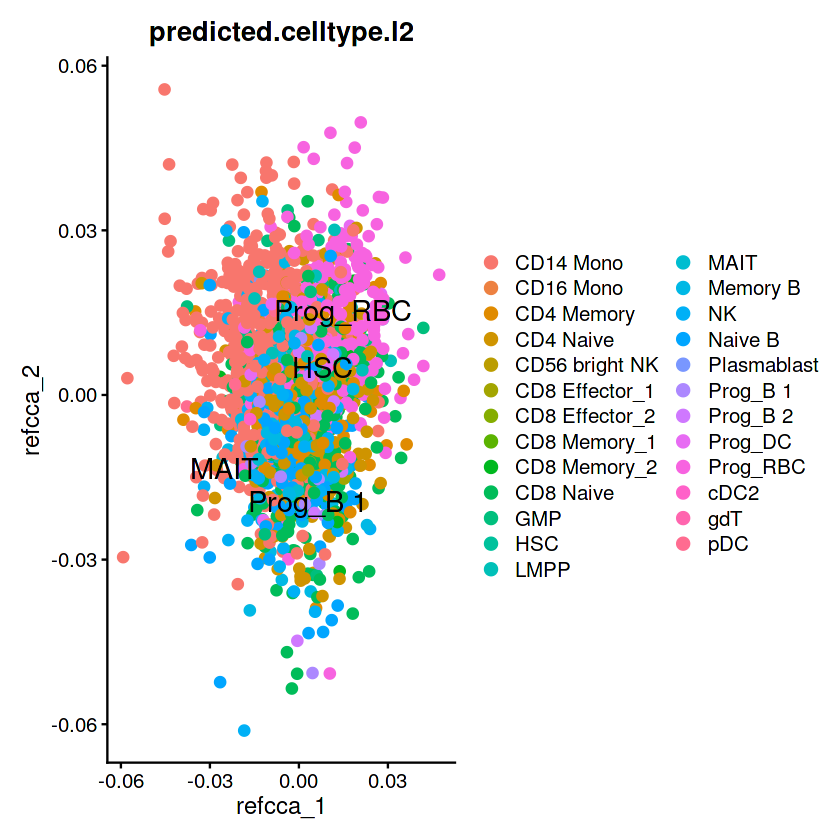

In [63]:
DimPlot(bm_filt, reduction = "ref.cca", group.by = "predicted.celltype.l2", label = TRUE, label.size = 6 ,repel = TRUE, pt.size = 2.5)


In [70]:
figures_dir = "../../../results/Fig1_Fig2_Fig3_SFig1-FACS_BM_scATAC/Fig3-apply_seurat_label_transfer/figures/"

Warning message:
"ggrepel: 6 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


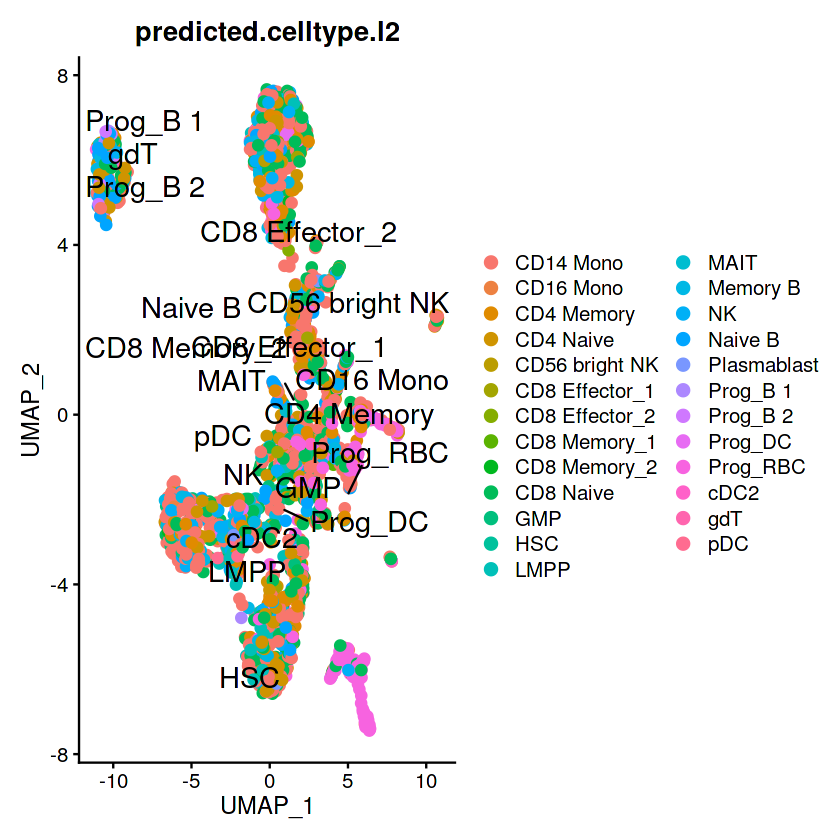

In [65]:
predicted_umap_plot  <- DimPlot(bm_filt, reduction = "umap", group.by = "predicted.celltype.l2", label = TRUE, label.size = 6 ,repel = TRUE, pt.size = 2.5)
predicted_umap_plot

In [72]:
ggsave(filename = paste(figures_dir , "predicted_umap.png", sep=''),predicted_umap_plot)

Saving 6.67 x 6.67 in image

Warning message:
"ggrepel: 6 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


In [68]:
predicted_umap_plot_aug <- AugmentPlot(plot = predicted_umap_plot, dpi=500)

In [71]:
ggsave(filename = paste(figures_dir , "predicted_umap_aug.png", sep=''),predicted_umap_plot_aug)

Saving 6.67 x 6.67 in image



In [73]:
real_id_plot <- DimPlot(bm_filt, reduction = "umap", group.by = "orig.ident", label = TRUE, label.size = 6 ,repel = TRUE, pt.size = 2.5)
real_id_plot_aug <-AugmentPlot(real_id_plot, width = 10, height = 10, dpi = 500)
ggsave(filename = paste(figures_dir , "real_id_plot_aug.png", sep=''),real_id_plot_aug)

Saving 6.67 x 6.67 in image



In [74]:
# save lenged separately
real_id_plot_w_legend <- DimPlot(bm_filt, reduction = "umap", group.by = "orig.ident", label = TRUE, label.size = 6 ,repel = TRUE, pt.size = 2.5) +  guides(color = guide_legend(override.aes = list(size=7), ncol=3) )

# Extract the legend. Returns a gtable
leg <- get_legend(real_id_plot_w_legend)

# Convert to a ggplot and print
save_plot(leg,filename = paste(figures_dir ,  "real_id_plot_legend.png", sep=''), dpi = 600)

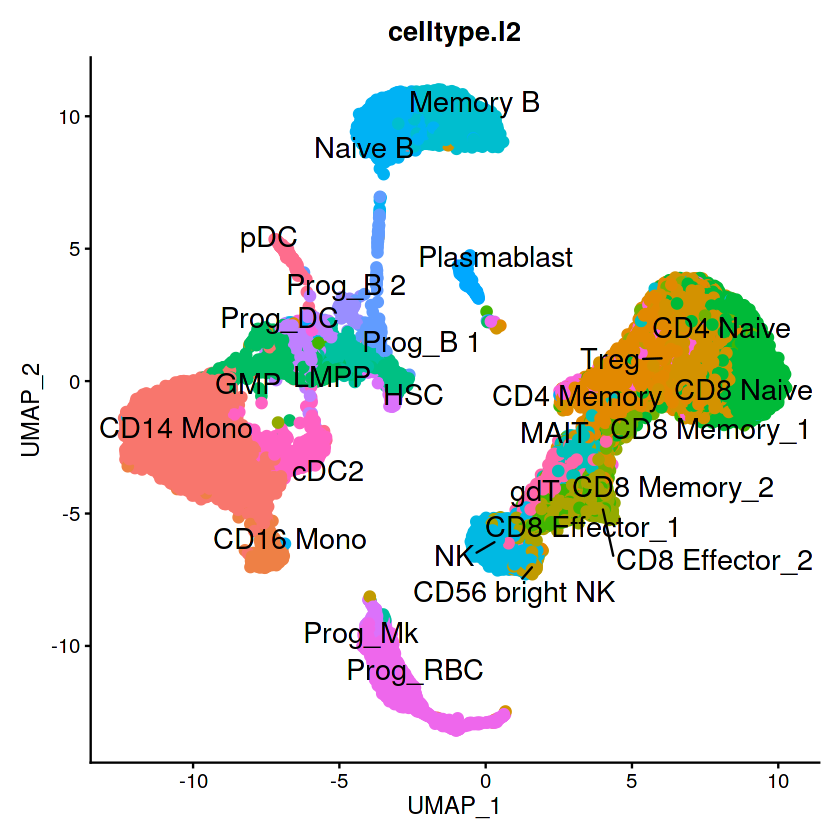

In [75]:
DimPlot(bm_ref, reduction = 'umap', group.by = 'celltype.l2', label = TRUE, label.size = 6,repel = TRUE, pt.size = 2.5) + NoLegend()


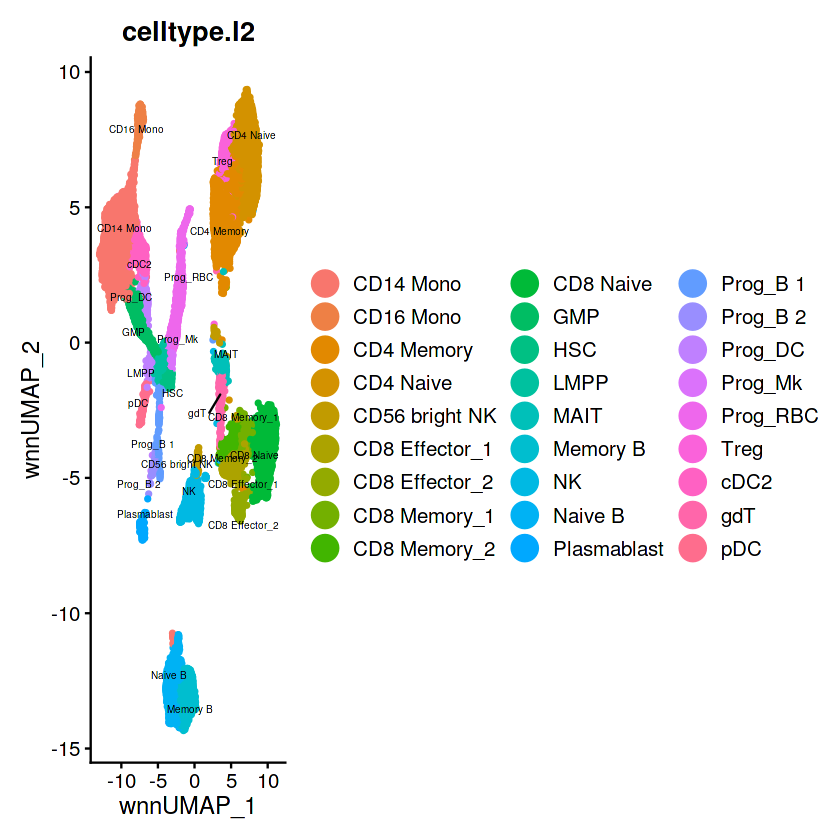

In [76]:
reference_bm_plot <- DimPlot(bm_ref, reduction = 'wnn.umap', group.by = 'celltype.l2', label = TRUE, label.size = 2,repel = TRUE, pt.size = 1)+  guides(color = guide_legend(override.aes = list(size=7), ncol=3) )
reference_bm_plot

In [82]:
# Extract the legend. Returns a gtable
leg <- get_legend(reference_bm_plot)
# Convert to a ggplot and print
save_plot(leg, filename = paste(figures_dir ,  "reference_bm_plot_aug_legend.png"), dpi = 600)
          

In [83]:
reference_bm_plot <- DimPlot(bm_ref, reduction = 'wnn.umap', group.by = 'celltype.l2', label = TRUE, label.size = 6,repel = TRUE, pt.size = 2.5) + NoLegend()
reference_bm_plot_aug <-AugmentPlot(reference_bm_plot, width = 10, height = 10, dpi = 500)
ggsave(filename =  paste(figures_dir , "reference_bm_plot_aug.png"),reference_bm_plot_aug)

Saving 6.67 x 6.67 in image



In [84]:
reference_bm_plot <- DimPlot(bm_ref, reduction = 'umap', group.by = 'celltype.l2', label = TRUE, label.size = 7,repel = TRUE, pt.size = 2.5) + NoLegend()
reference_bm_plot_aug <-AugmentPlot(reference_bm_plot, width = 10, height = 10, dpi = 500)
ggsave(filename =  paste(figures_dir , "reference_bm_umap_plot_aug.png"),reference_bm_plot_aug)

Saving 6.67 x 6.67 in image



## export gene activity matrix for marker based annotation:

In [92]:
write.csv(as.matrix(gene.activities), "../../../results/Fig1_Fig2_Fig3_SFig1-FACS_BM_scATAC/Fig3-apply_seurat_label_transfer/gene_activity_mtx/gene_activities.csv")

In [3]:
write.csv(bm_filt@meta.data, "../../../results/Fig1_Fig2_Fig3_SFig1-FACS_BM_scATAC/Fig3-apply_seurat_label_transfer/buenrostro2018_Seurat4_labeltransfer_metadata.csv",row.names = T)